# gpHSP overview

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Common libraries
from IPython.display import display
import seaborn as sns
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
from collections import OrderedDict
# Importing GPmol
import gpmol as gpm
from gpmol.utils.plotting import html_header, write_latex_table
from gpmol.utils.general import delatexfy, save_dict
print(gpm.__version__)
from tqdm import tqdm_notebook as tqdm
gpm.plot_settings()
gpm.pandas_settings()
gpm.logging.set_level('warning')
gpm.settings['save_results'] = False

Running in Jupyter notebook 
0.9.3


## utility

In [3]:
import py3Dmol
from rdkit import Chem

def view_mol_3D(smiles):
    mol = gpm.data_transforms.smi2mol(smiles)
    mol = gpm.data_transforms.mol2molxyz(mol)
    sdf = Chem.MolToMolBlock(mol)
    xyzview = py3Dmol.view(width=400, height=400)
    xyzview.addModel(sdf, 'sdf')
    xyzview.setViewStyle(
        {'style': 'outline', 'color': 'black', 'width': 0.05})
    xyzview.setStyle({'stick': {'radius': .1}, 'sphere': {'scale': 0.25}})
    xyzview.zoomTo()
    disp = xyzview.show()
    return disp

# Solvent: Load Data

In [4]:
from gpmol.utils.general import str2array
df = pd.read_csv('data/Solvents_exp.csv')
df['sigma_profile']=df['sigma_profile'].apply(str2array)
print(df.columns)
print(df.shape)
df.head(1)

Index(['key', 'Type', 'δd', 'δp', 'δh', 'smiles', 'ID_type', 'ID', 'Ref',
       'organic', 'n_electrons', 'n_atoms', 'charge', 'MolWt', 'label',
       'finished', 'job_name', 'homo', 'lumo', 'gap', 'd-moments', 'dipole',
       'polar', 'run_time', 'n_cores', 'compute_time', 'Area', 'Hba', 'Hbd',
       'Volume', 'sigma_mom_0', 'sigma_mom_1', 'sigma_mom_2', 'sigma_mom_3',
       'sigma_mom_4', 'sigma_mom_5', 'sigma_norm', 'sigma_profile', 'drug'],
      dtype='object')
(193, 39)


,key,Type,δd,δp,δh,smiles,ID_type,ID,Ref,organic,...,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile,drug
0,"1,1,1-Trichloroethane",Solvent,16.80,4.30,2.00,CC(Cl)(Cl)Cl,CAS,71-55-6,1,True,...,0.13,0,16.60,-3.84,4.24,-2.02,1.54,41.43,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False


## Make features

In [5]:
from gpmol.features import RegressionTarget, MorganFP,MACCSFP, Properties, Vector
from gpmol.data_transforms import SMILES2MOL
targets = [RegressionTarget('δd', name='$\delta d$',units='$MPa^{0.5}$',suffix='exp'),
           RegressionTarget('δp', name='$\delta p$',units='$MPa^{0.5}$',suffix='exp'),
           RegressionTarget('δh', name='$\delta h$',units='$MPa^{0.5}$',suffix='exp')]

features = OrderedDict()
features['FPb']=MorganFP()
features['FPc']=MorganFP(fptype='count',transforms='Normalize')
features['MACCS']=MACCSFP()
features['SigmaP']=Vector('sigma_profile',name='SigmaP')
features['ElectroS']=Properties(['dipole','polar','sigma_norm','Hba','Hbd'],name='ElectroS')
features['Size']=Properties(['MolWt','Area','Volume'],name='Size/Shape')

feats=OrderedDict()
feats['δd']=['FPb','SigmaP','ElectroS','Size']
feats['δh']=['FPb','SigmaP','ElectroS','Size']
feats['δp']=['FPb','SigmaP','ElectroS','Size']

## Train Experimental Model

In [6]:
gps=OrderedDict()
for indx,t in enumerate(targets):
    html_header('{}'.format(t.name))
    preproc = gpm.Preprocessor(df)
    preproc.append(t)
    preproc.append(SMILES2MOL(smi_col='smiles',mol_col='mol'))
    preproc.append([ features[fname] for fname in feats[t.cols[0]]])
    gp = preproc.make_gpmol(t.cols[0])
    gp.minimize()
    gps[t.cols[0]]=gp

Shape of x must be 2D at computation. 


Shape of x must be 2D at computation. 


Shape of x must be 2D at computation. 


# Solvents: Predict on another dataset
## Load data

In [7]:
from gpmol.utils.general import str2array
ex_df = pd.read_csv('data/HSPiP.csv')
ex_df['sigma_profile']=ex_df['sigma_profile'].apply(str2array)
print(ex_df.columns)
print(ex_df.shape)
ex_df.head(1)

Index(['Chemical', 'CAS', 'smiles', 'HSPiP_indx', 'good_smiles', 'single_frag',
       'duplicated', 'sanity', 'label', 'organic', 'n_electrons', 'n_atoms',
       'charge', 'MolWt', 'homo', 'lumo', 'gap', 'd-moments', 'dipole',
       'polar', 'run_time', 'n_cores', 'compute_time', 'Area', 'Hba', 'Hbd',
       'Volume', 'sigma_mom_0', 'sigma_mom_1', 'sigma_mom_2', 'sigma_mom_3',
       'sigma_mom_4', 'sigma_mom_5', 'sigma_norm', 'sigma_profile'],
      dtype='object')
(8852, 35)


,Chemical,CAS,smiles,HSPiP_indx,good_smiles,single_frag,duplicated,sanity,label,organic,...,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile
0,Acetaldehyde,75-07-0,CC=O,0,True,True,True,True,hspip_0,True,...,0.00,0.06,0,33.00,18.40,30.60,30.10,39.10,22.20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## For a single molecule

### Let's pick a random molecule

In [8]:
row = ex_df.sample(n=1)
html_header(row['Chemical'].iloc[0])
display(row)
view_mol_3D(row['smiles'].values[0])

,Chemical,CAS,smiles,HSPiP_indx,good_smiles,single_frag,duplicated,sanity,label,organic,...,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile
7497,hexanal dibutyl acetal,93892-07-0,CCCCCC(OCCCC)OCCCC,8542,True,True,True,True,hspip_8542,True,...,0.00,0.34,0,33.20,22.50,33.80,43.70,61.40,103.82,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

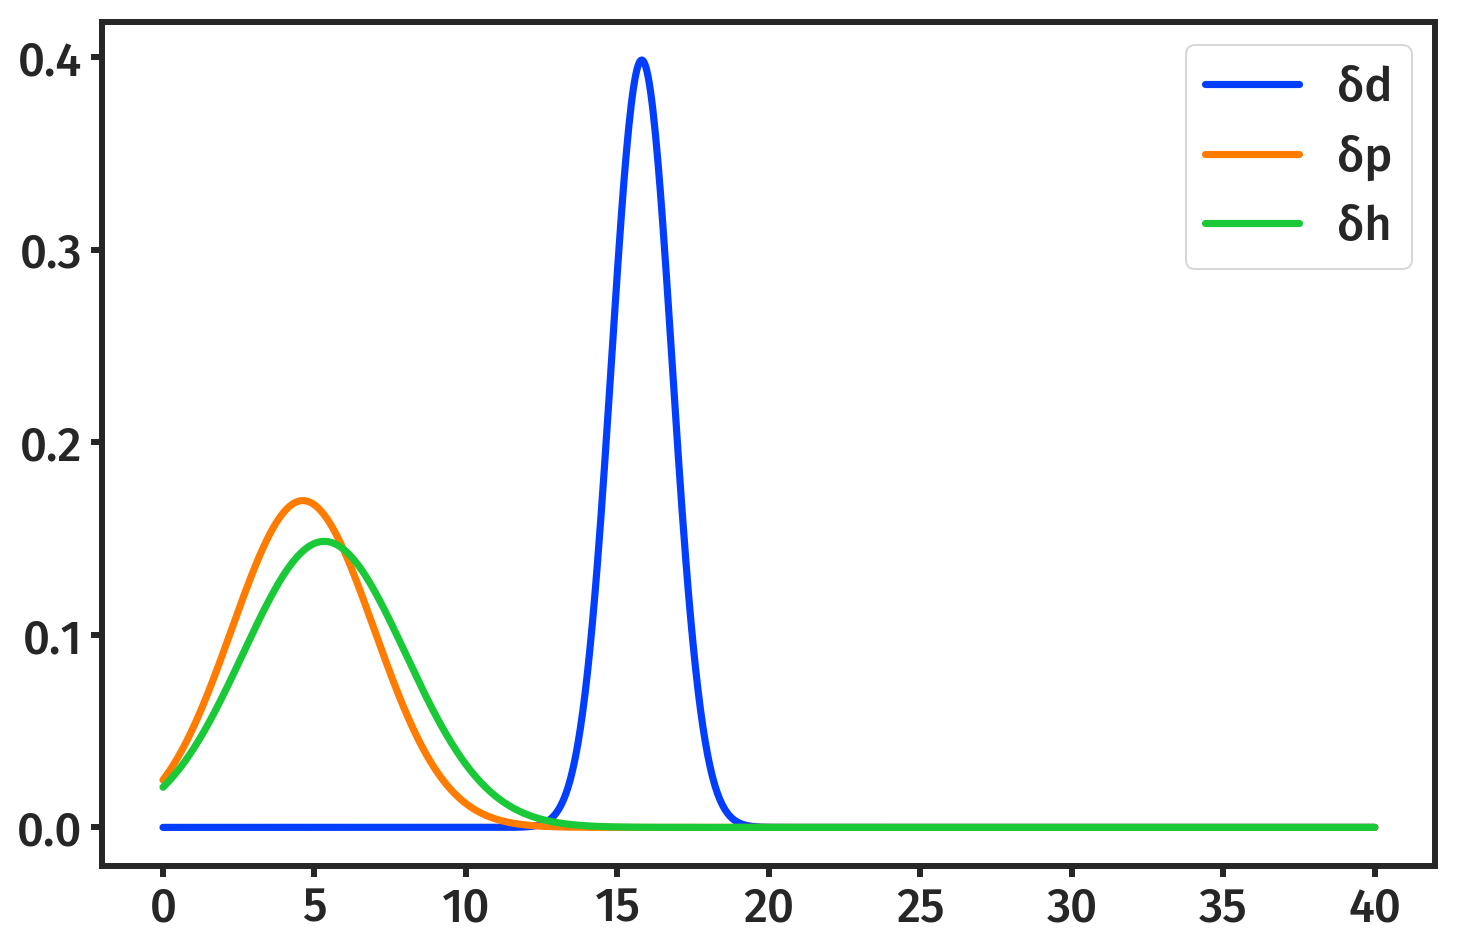

In [9]:
from scipy.stats import norm

x = np.linspace(0,40,1000)
for name, gp in gps.items():
    preproc = gp.preprocessor
    X_test = preproc.transformX(row)
    Y_pred, Y_std = gp.predict(X_test)
    plt.plot(x,norm.pdf(x,Y_pred.ravel()[0],Y_std.ravel()[0]),label=name)
plt.legend(loc='best')
plt.show()

## Calculate on an entire dataset

In [10]:
for name, gp in tqdm(gps.items(),total=len(gps)):
    X_test = gp.preprocessor.transformX(ex_df)
    Y_pred, Y_std = gp.predict(X_test)
    ex_df['{}_gp_pred'.format(name)]=Y_pred.ravel()
    ex_df['{}_gp_std'.format(name)]=Y_std.ravel()
ex_df.to_csv('results/HSPiP_predictions.csv',index=False)
ex_df.head()

,Chemical,CAS,smiles,HSPiP_indx,good_smiles,single_frag,duplicated,sanity,label,organic,...,sigma_mom_5,sigma_norm,sigma_profile,mol,δd_gp_pred,δd_gp_std,δp_gp_pred,δp_gp_std,δh_gp_pred,δh_gp_std
0,Acetaldehyde,75-07-0,CC=O,0,True,True,True,True,hspip_0,True,...,39.10,22.20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381a1ab20>,15.66,0.42,10.04,1.91,6.05,1.41
1,Acetaldoxime,107-29-9,C/C=N/O,1,True,True,True,True,hspip_1,True,...,324.00,21.89,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381a1a5d0>,15.87,0.47,6.40,2.42,12.40,2.26
2,Acetamide,60-35-5,CC(N)=O,2,True,True,True,True,hspip_2,True,...,221.00,19.35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381a1a350>,17.65,0.52,19.53,2.26,18.60,1.73
3,Acetanilide,103-84-4,CC(=O)Nc1ccccc1,3,True,True,True,True,hspip_3,True,...,158.00,40.87,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381a1a990>,19.55,0.76,9.06,1.97,8.58,1.77
4,Acetic Acid,64-19-7,CC(=O)O,4,True,True,True,True,hspip_4,True,...,411.00,19.38,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00087716...",<rdkit.Chem.rdchem.Mol object at 0x7f2381a1a620>,15.27,0.46,5.87,2.32,14.68,2.34


# Polymers: Train model

## Load data

In [11]:
from gpmol.utils.general import str2array
poly_df = pd.read_csv('data/Polymers_exp.csv')
poly_df['sigma_profile']=poly_df['sigma_profile'].apply(str2array)
print(poly_df.columns)
print(poly_df.shape)
poly_df.head(1)

Index(['label', 'δd', 'δp', 'δh', 'smiles', 'test', 'poly_label', 'n_copies',
       'organic', 'n_electrons', 'n_atoms', 'charge', 'MolWt', 'n_frags',
       'largest', 'finished', 'job_name', 'poly_smiles', 'homo', 'lumo', 'gap',
       'd-moments', 'dipole', 'polar', 'run_time', 'n_cores', 'compute_time',
       'Area', 'Hba', 'Hbd', 'Volume', 'sigma_mom_0', 'sigma_mom_1',
       'sigma_mom_2', 'sigma_mom_3', 'sigma_mom_4', 'sigma_mom_5',
       'sigma_norm', 'sigma_profile'],
      dtype='object')
(31, 39)


,label,δd,δp,δh,smiles,test,poly_label,n_copies,organic,n_electrons,...,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile
0,Polyacrylonitrile-n5,20.00,15.10,7.90,CCC#N,True,Polyacrylonitrile,5,True,110,...,0.22,0.34,0,175.00,26.10,154.00,51.40,165.00,66.77,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Step 1: Calculate "Solvent" HSP and difference

In [12]:
for name, gp in gps.items():
    X_test = gp.preprocessor.transformX(poly_df)
    Y_pred, Y_std = gp.predict(X_test)
    poly_df['{}_gpsolv'.format(name)]=Y_pred.ravel()
    poly_df['{}_diff'.format(name)]=poly_df[name]-Y_pred.ravel()

poly_df.head()

,label,δd,δp,δh,smiles,test,poly_label,n_copies,organic,n_electrons,...,sigma_mom_5,sigma_norm,sigma_profile,mol,δd_gpsolv,δd_diff,δp_gpsolv,δp_diff,δh_gpsolv,δh_diff
0,Polyacrylonitrile-n5,20.00,15.10,7.90,CCC#N,True,Polyacrylonitrile,5,True,110,...,165.00,66.77,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381871030>,15.86,4.14,22.19,-7.09,8.08,-0.18
1,Polyethylene-n5,16.90,0.80,2.80,CC,True,Polyethylene,5,True,70,...,0.02,91.88,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381871e90>,15.49,1.41,1.14,-0.34,2.55,0.25
2,Polypropylene-n5,18.00,0.00,1.00,CCC,True,Polypropylene,5,True,100,...,0.03,112.13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381871530>,15.56,2.44,1.72,-1.72,4.11,-3.11
3,Polystyrene-n5,18.70,5.90,3.50,CCc1ccccc1,True,Polystyrene,5,True,210,...,8.33,139.09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381871260>,17.77,0.93,2.60,3.30,6.20,-2.70
4,Polyvinylchloride-n5,18.80,9.20,6.30,CCCl,True,Polyvinylchloride,5,True,100,...,5.48,80.14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2381871cb0>,18.22,0.58,11.35,-2.15,2.84,3.46


## Step 2: Train polymer model on difference
### Define features

In [13]:
from gpmol.features import RegressionTarget, MorganFP,MACCSFP, Properties, Vector
from gpmol.data_transforms import SMILES2MOL

targets = [RegressionTarget('δd_diff', name='$\delta d_{diff}$',units='$MPa^{0.5}$',suffix='exp'),
           RegressionTarget('δp_diff', name='$\delta p_{diff}$',units='$MPa^{0.5}$',suffix='exp'),
           RegressionTarget('δh_diff', name='$\delta h_{diff}$',units='$MPa^{0.5}$',suffix='exp')]

features = OrderedDict()

features['FPb']=MorganFP(col='poly_mol')
features['FPc']=MorganFP(fptype='count',col='poly_mol')
features['MACCS']=MACCSFP(col='poly_mol')
features['SigmaP']=Vector('sigma_profile',name='SigmaP')
features['ElectroS']=Properties(['dipole','polar','sigma_norm','Hba','Hbd'],name='ElectroS')
features['Size']=Properties(['MolWt','Area','Volume'],name='Size/Shape')

feats=OrderedDict()
feats['δd']=['FPb','SigmaP','ElectroS','Size']
feats['δh']=['FPb','SigmaP','ElectroS','Size']
feats['δp']=['FPb','SigmaP','ElectroS','Size']

### Train on experimental polymer data

In [14]:
poly_gps=OrderedDict()
for indx,t in enumerate(targets):
    html_header('{}'.format(t.name))
    t_name= t.cols[0].replace('_diff','')
    preproc = gpm.Preprocessor(poly_df)
    preproc.append(t)
    preproc.append(SMILES2MOL(smi_col='poly_smiles',mol_col='poly_mol'))
    preproc.append([ features[fname] for fname in feats[t_name]])
    gp = preproc.make_gpmol(t_name)
    gp.minimize()
    poly_gps[t_name]=gp

Shape of x must be 2D at computation. 


Shape of x must be 2D at computation. 


Shape of x must be 2D at computation. 


# Polymers predict on another set
## Load data

In [15]:
from gpmol.utils.general import str2array
ex_df = pd.read_csv('data/PNT.csv')
ex_df['sigma_profile']=ex_df['sigma_profile'].apply(str2array)
print(ex_df.columns)
print(ex_df.shape)
ex_df.head(1)

Index(['label', 'smiles', 'organic', 'n_electrons', 'n_atoms', 'charge',
       'MolWt', 'finished', 'job_name', 'poly_smiles', 'homo', 'lumo', 'gap',
       'd-moments', 'dipole', 'polar', 'run_time', 'n_cores', 'compute_time',
       'Area', 'Hba', 'Hbd', 'Volume', 'sigma_mom_0', 'sigma_mom_1',
       'sigma_mom_2', 'sigma_mom_3', 'sigma_mom_4', 'sigma_mom_5',
       'sigma_norm', 'sigma_profile'],
      dtype='object')
(53, 31)


,label,smiles,organic,n_electrons,n_atoms,charge,MolWt,finished,job_name,poly_smiles,...,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile
0,PNT-001,CCCCCCCCCC[C@@H](CCCCCCCC)Cc1csc(-c2cc3c(cc(-c...,True,402,164,0,"1,107.85",True,SOLSPE2_PNT-001,CCCCCCCCCC[C@@H](CCCCCCCC)Cc1csc(c2cc3c(cc(c4c...,...,0.00,1.43,0,92.70,1.42,35.30,3.07,24.30,349.65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## For a single Molecule

In [16]:
row = ex_df.sample(n=1)
html_header(row['label'].iloc[0])
display(row)
view_mol_3D(row['smiles'].values[0])

,label,smiles,organic,n_electrons,n_atoms,charge,MolWt,finished,job_name,poly_smiles,...,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile
17,PNT-018,CCCC[C@H](CC)CSc1sc(-c2c3cc(-c4sc(-c5cc6c(cc(-...,True,432,156,0,"1,282.01",True,SOLSPE2_PNT-018,Fc1cc(sc1SC[C@@H](CC)CCCC)c1c2cc(c3c(cc(c4c5ns...,...,0.00,1.55,0,115.00,7.88,53.20,16.20,46.70,361.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Step 1: Calculate "Solvent" HSP 
## Step 2: Calculate "Polymer" correction
## Step 3: Add

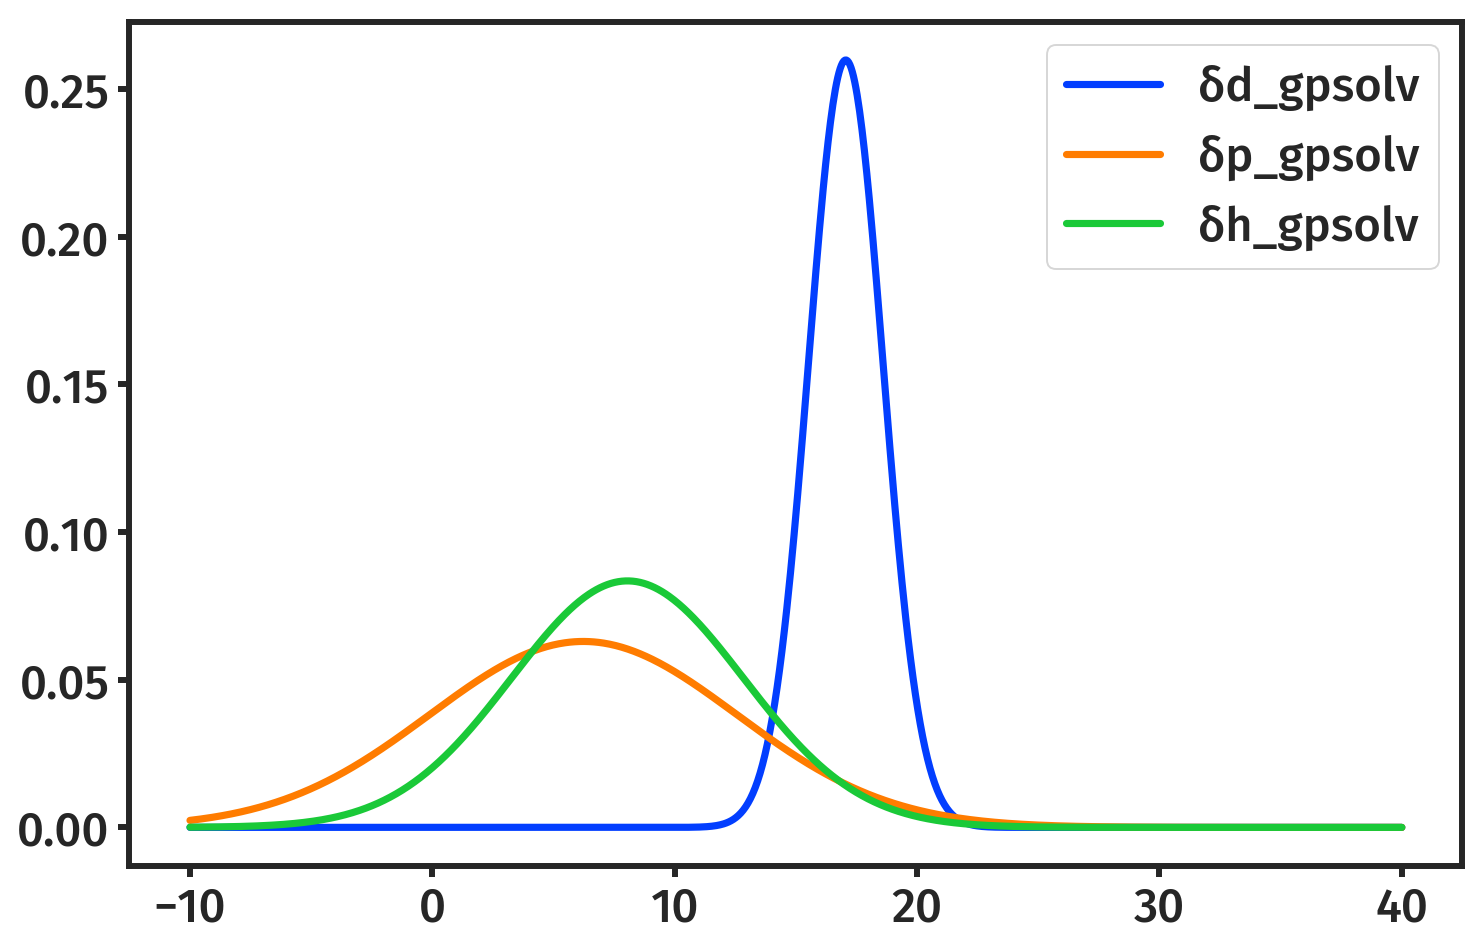

,label,smiles,organic,n_electrons,n_atoms,charge,MolWt,finished,job_name,poly_smiles,...,sigma_mom_5,sigma_norm,sigma_profile,mol,δd_gpsolv,δd_gpsolv_std,δp_gpsolv,δp_gpsolv_std,δh_gpsolv,δh_gpsolv_std
17,PNT-018,CCCC[C@H](CC)CSc1sc(-c2c3cc(-c4sc(-c5cc6c(cc(-...,True,432,156,0,"1,282.01",True,SOLSPE2_PNT-018,Fc1cc(sc1SC[C@@H](CC)CCCC)c1c2cc(c3c(cc(c4c5ns...,...,46.70,361.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7f2359d48210>,17.06,1.54,6.23,6.34,8.05,4.78


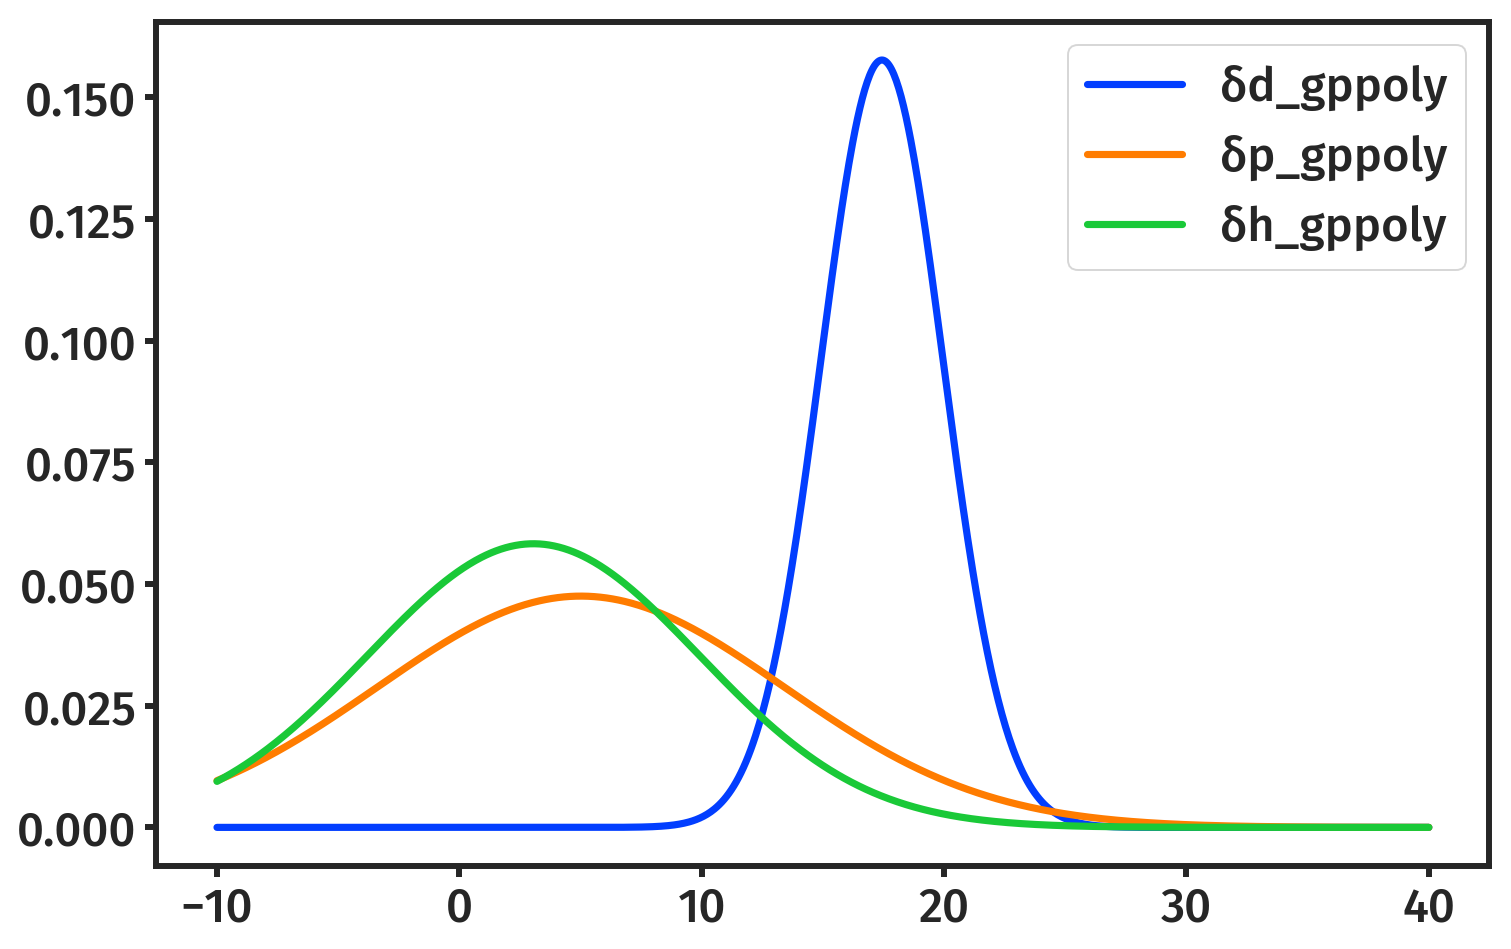

In [17]:
from scipy.stats import norm

x = np.linspace(-10,40,1000)
for name, gp in gps.items():
    X_test = gp.preprocessor.transformX(row)
    Y_pred, Y_std = gp.predict(X_test)
    row['{}_gpsolv'.format(name)] = Y_pred.ravel()
    row['{}_gpsolv_std'.format(name)] = Y_std.ravel()
    plt.plot(x,norm.pdf(x,Y_pred.ravel()[0],Y_std.ravel()[0]),label='{}_gpsolv'.format(name))
plt.legend(loc='best')
plt.show()
display(row)
for name, gp in poly_gps.items():
    X_test = gp.preprocessor.transformX(row)
    Y_pred, Y_std = gp.predict(X_test)
    row['{}_gppoly_pred'.format(name)]=Y_pred.ravel()
    row['{}_gppoly_std'.format(name)]=Y_std.ravel()
    row['{}_gp_pred'.format(name)]=row['{}_gpsolv'.format(name)]+Y_pred.ravel()
    row['{}_gp_std'.format(name)]=row['{}_gpsolv_std'.format(name)]+Y_std.ravel()
    mu = row['{}_gp_pred'.format(name)].values[0]
    sigma = row['{}_gp_std'.format(name)].values[0]
    plt.plot(x,norm.pdf(x,mu,sigma),label='{}_gppoly'.format(name))

plt.legend(loc='best')
plt.show()

# Polymers: Predict on all data

### Steps:
1. Calculate "Solvent" HSP 
2. Calculate "Polymer" correction
3. Add together

In [18]:
from scipy.stats import norm

x = np.linspace(-10,40,1000)
for name, gp in gps.items():
    X_test = gp.preprocessor.transformX(ex_df)
    Y_pred, Y_std = gp.predict(X_test)
    ex_df['{}_gpsolv'.format(name)] = Y_pred.ravel()
    ex_df['{}_gpsolv_std'.format(name)] = Y_std.ravel()


for name, gp in poly_gps.items():
    X_test = gp.preprocessor.transformX(ex_df)
    Y_pred, Y_std = gp.predict(X_test)
    ex_df['{}_gppoly_pred'.format(name)]=Y_pred.ravel()
    ex_df['{}_gppoly_std'.format(name)]=Y_std.ravel()
    ex_df['{}_gp_pred'.format(name)]=ex_df['{}_gpsolv'.format(name)]+Y_pred.ravel()
    ex_df['{}_gp_std'.format(name)]=ex_df['{}_gpsolv_std'.format(name)]+Y_std.ravel()

ex_df.to_excel('results/PNT_predictions.xlsx',index=False)
ex_df.head()

,label,smiles,organic,n_electrons,n_atoms,charge,MolWt,finished,job_name,poly_smiles,...,δd_gp_pred,δd_gp_std,δp_gppoly_pred,δp_gppoly_std,δp_gp_pred,δp_gp_std,δh_gppoly_pred,δh_gppoly_std,δh_gp_pred,δh_gp_std
0,PNT-001,CCCCCCCCCC[C@@H](CCCCCCCC)Cc1csc(-c2cc3c(cc(-c...,True,402,164,0,"1,107.85",True,SOLSPE2_PNT-001,CCCCCCCCCC[C@@H](CCCCCCCC)Cc1csc(c2cc3c(cc(c4c...,...,19.93,2.52,-0.43,1.77,4.45,7.98,-3.08,2.60,5.64,7.35
1,PNT-002,CCCCCCCCCCc1cc(-c2c3cc(-c4sc(-c5ccc(-c6cc(CCCC...,True,508,213,0,"1,382.37",True,SOLSPE2_PNT-002,c1c(cc(s1)c1ccc(c2c1nsn2)[C]1C=C([C](S1)c1cc2c...,...,18.58,2.76,-1.61,1.84,3.74,8.19,-2.07,2.70,6.72,7.48
2,PNT-003,CCCCCCCCCC[C@@H](CCCCCCCC)Cc1csc(-c2cc3c(cc(-c...,True,412,167,-1,"1,132.88",True,SOLSPE2_PNT-003,CCCCCCCCCC[C@@H](CCCCCCCC)C/C(=C/[C@@H](S)c1cc...,...,20.23,2.21,-0.31,1.70,4.05,8.03,-5.05,2.37,2.24,7.17
3,PNT-004,CCCCCCCCCC[C@@H](CCCCCCCC)Cc1csc(-c2cc3c(cc(-c...,True,388,160,-1,"1,050.76",True,SOLSPE2_PNT-004,CCCCCCCCCC[C@@H](CCCCCCCC)Cc1csc(c2cc3c(cc(c4c...,...,19.28,2.10,-0.24,1.58,4.12,7.77,-4.47,2.28,3.43,6.97
4,PNT-005,CCCCCCCCCCCC[C@H](CCCCCCCCCC)Cc1csc(-c2cc3c(cc...,True,436,185,0,"1,163.98",True,SOLSPE2_PNT-005,CCCCCCCCCCCC[C@H](CCCCCCCCCC)Cc1csc(c2cc3c(cc(...,...,19.64,2.11,-0.10,1.57,3.77,7.84,-4.47,2.28,2.38,7.04
